<a href="https://colab.research.google.com/github/syamjithz/Number_Plate_Detection/blob/main/Number_Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get update
!apt-get install tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.ne

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
path = glob('../content/drive/MyDrive/Number_plate_detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../content/drive/MyDrive/Number_plate_detectio...,31,139,128,161
1,../content/drive/MyDrive/Number_plate_detectio...,813,1067,665,724
2,../content/drive/MyDrive/Number_plate_detectio...,1093,1396,645,727
3,../content/drive/MyDrive/Number_plate_detectio...,134,301,312,350
4,../content/drive/MyDrive/Number_plate_detectio...,66,154,166,197


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../content/drive/MyDrive/Number_plate_detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../content/drive/MyDrive/Number_plate_detection/images/N101.jpeg'

In [ ]:
#random checking
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['../content/drive/MyDrive/Number_plate_detection/images/N101.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N103.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N1.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N100.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N104.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N102.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N106.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N107.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N105.jpeg',
 '../content/drive/MyDrive/Number_plate_detection/images/N108.jpeg']


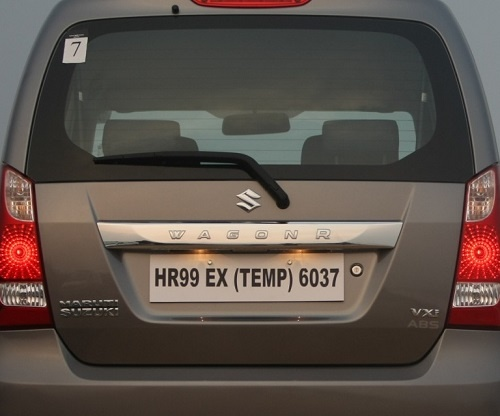

In [ ]:
file_path = image_path[45]
img = cv2.imread(file_path)
img = io.imread(file_path)
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=150, x1=346, y0=248, y1=301, xref='x', yref='y',line_color='cyan')

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for i in range(len(image_path)):
    image = image_path[i]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[i]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

Split and train

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

Deep learning model

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

**Inception-Resnet-v2 training and save**

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=150,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/150
18/18 [==============================] - 19s 437ms/step - loss: 7.2095e-05 - val_loss: 0.0089
Epoch 2/150
18/18 [==============================] - 5s 262ms/step - loss: 6.9339e-05 - val_loss: 0.0074
Epoch 3/150
18/18 [==============================] - 4s 246ms/step - loss: 7.3112e-05 - val_loss: 0.0059
Epoch 4/150
18/18 [==============================] - 5s 264ms/step - loss: 9.6259e-05 - val_loss: 0.0058
Epoch 5/150
18/18 [==============================] - 4s 248ms/step - loss: 9.2392e-05 - val_loss: 0.0058
Epoch 6/150
18/18 [==============================] - 5s 266ms/step - loss: 8.6308e-05 - val_loss: 0.0057
Epoch 7/150
18/18 [==============================] - 4s 250ms/step - loss: 6.4434e-05 - val_loss: 0.0057
Epoch 8/150
18/18 [==============================] - 5s 267ms/step - loss: 4.9908e-05 - val_loss: 0.0058
Epoch 9/150
18/18 [==============================] - 5s 269ms/step - loss: 6.5600e-05 - val_loss: 0.0057
Epoch 10/150
18/18 [==============================] - 

In [ ]:
model.save('./object_detection.h5')

Predictions

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '../content/drive/MyDrive/Number_plate_detection/TEST/TEST.jpeg'
image = load_img(path)
image = np.array(image,dtype=np.uint8)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901



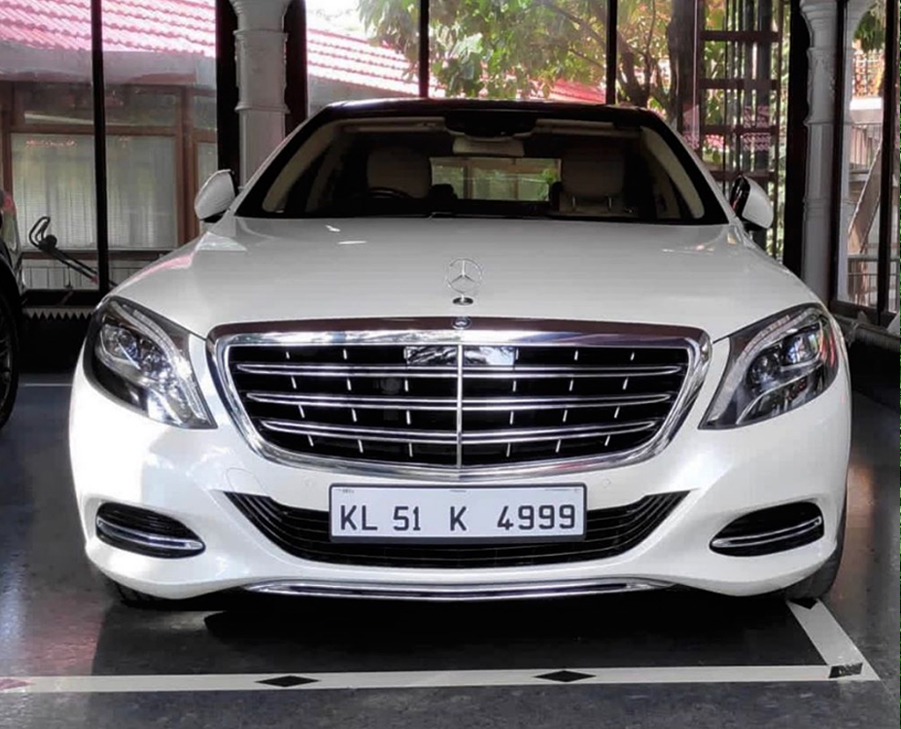

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 4s 4s/step


array([[0.3535157 , 0.6392369 , 0.6416078 , 0.73548436]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[318.51765868, 575.95247126, 467.7321015 , 536.16809964]])

Making Bounding Box

In [ ]:
coords = coords.astype(np.int32)
coords

array([[318, 575, 467, 536]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin,xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(318, 467) (575, 536)



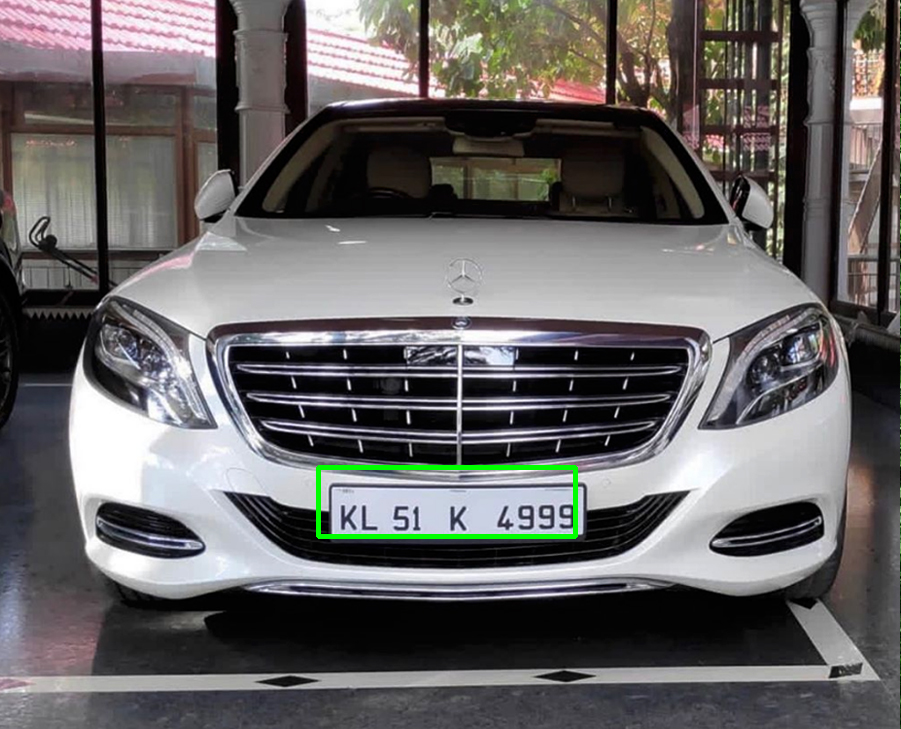

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 [==============================] - 0s 62ms/step
(318, 467) (575, 536)



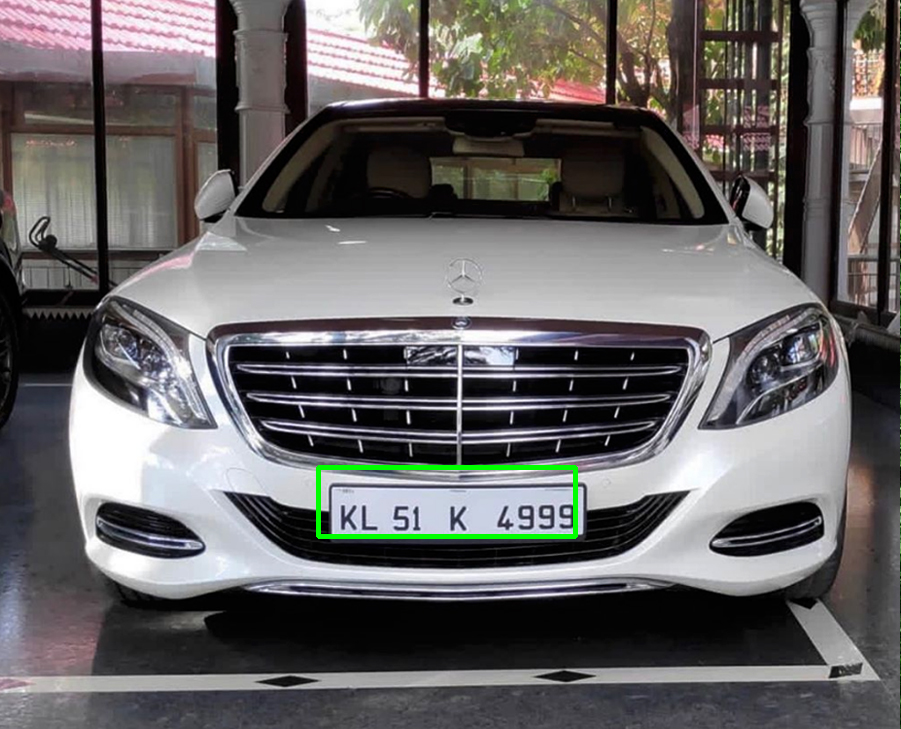

In [ ]:
# Create pipeline
path = '../content/drive/MyDrive/Number_plate_detection/TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path)
    image = np.array(image,dtype=np.uint8)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

**Extracting text from number plate**


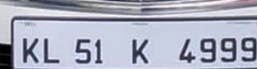

In [ ]:
img = np.array(load_img(path))
xmin,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [ ]:
# extract text from image
text = pytesseract.image_to_string(roi)
print(text)

SS
KL 51 K 4999

